In [9]:
def plotHist(data, bins=[], x_labels=True):
    data_hist = np.random.randn(82)
    fig, ax = plt.subplots(figsize=(24,5))
    if bins: 
        counts, bins, patches = ax.hist(data, bins=bins, facecolor='yellow', edgecolor='gray')
    else:
        counts, bins, patches = ax.hist(data, facecolor='yellow', edgecolor='gray')

    # Set the ticks to be at the edges of the bins.
    if x_labels:
        ax.set_xticks(bins)
        # Set the xaxis's tick labels to be formatted with 1 decimal place...
        ax.xaxis.set_major_formatter(FormatStrFormatter('%0.05f'))

    # Change the colors of bars at the edges...
    twentyfifth, seventyfifth = np.percentile(data_hist, [25, 75])
    for patch, rightside, leftside in zip(patches, bins[1:], bins[:-1]):
        if rightside < twentyfifth:
            patch.set_facecolor('green')
        elif leftside > seventyfifth:
            patch.set_facecolor('red')

    # Label the raw counts and the percentages below the x-axis...
    if x_labels:
        bin_centers = 0.5 * np.diff(bins) + bins[:-1]
        for count, x in zip(counts, bin_centers):
            # Label the raw counts
            ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
                xytext=(0, -18), textcoords='offset points', va='top', ha='center')

            # Label the percentages
            percent = '%0.0f%%' % (100 * float(count) / counts.sum())
            ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
                xytext=(0, -32), textcoords='offset points', va='top', ha='center')


    # Give ourselves some more room at the bottom of the plot
    plt.subplots_adjust(bottom=0.1)
    plt.show()

In [7]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import pickle
import json
import string
import re
from collections import defaultdict

from random import randint, shuffle
from tqdm import tqdm

import numpy as np
import nltk
import pandas as pd
from nltk import ngrams

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint

seed = 7
np.random.seed(seed)
pd.set_option('max_colwidth', -1)

Using TensorFlow backend.


In [8]:
def load_data(filename):
    with open(f"{filename}.json", "rb") as f:
        data = json.load(f)
    print("Loaded data!")
    return data
        
def save_data(data, filename):
    with open(f"{filename}.pkl", "wb") as f:
        pickle.dump(data, f)
        
def export_to_json(data):
    with open('matches.json', 'w') as json_file:
        json.dump(data, json_file)
    
i1b = lambda m : m['commentary']['innings1']['balls']
i2b = lambda m : m['commentary']['innings2']['balls']
i1o = lambda m : m['commentary']['innings1']['over_summaries']
i2o = lambda m : m['commentary']['innings2']['over_summaries']

In [9]:
data, players = load_data("matches_Dale Steyn2611"), load_data("player_table")

Loaded data!
Loaded data!


In [10]:
lines, lengths = [], []
for i, m in data.items():
    for ball in i1b(m):
        if ball['pitch']:
            lengths.append(ball['pitch']['length'])
            lines.append(ball['pitch']['line'])
    for ball in i2b(m):
        if ball['pitch']:
            lengths.append(ball['pitch']['length'])
            lines.append(ball['pitch']['line'])

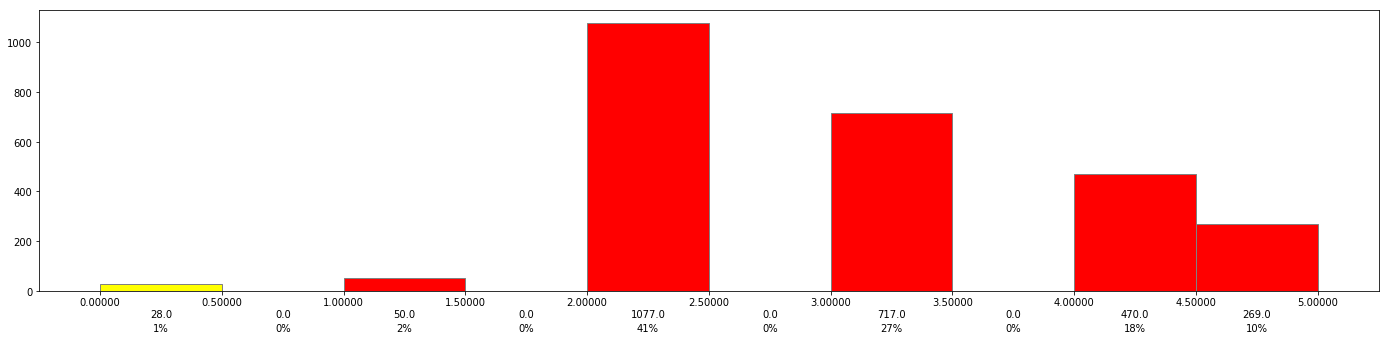

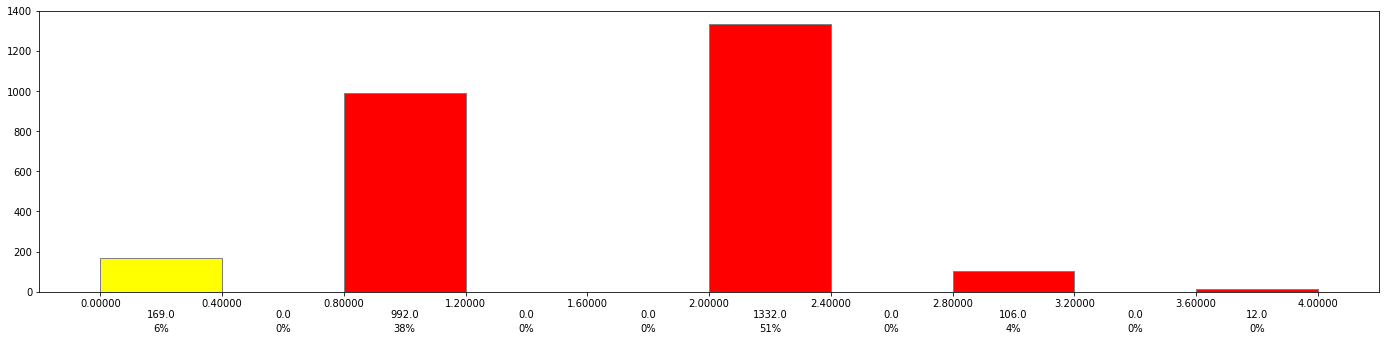

In [17]:
plotHist(lengths)
plotHist(lines)

In [21]:
all_names = set()
ambigNames = set(['short', 'ball', 'head', 'little', 'chase', 'cutting', 'cross'])
for profile in players.values():
    name = profile['known_as'].split(' ')
    ambig = any(n.lower() in ambigNames for n in name)
    if not ambig:
        all_names.update(name)
        all_names.update([n.lower() for n in name])

In [22]:
rows = []
bowlerPattern = "(?P<bowler>[\w \-'?]+) to (?P<batsman>[\w \-']+),(?P<text_outcome>[^,]*),(?P<desc>.*)$"
def getRow(b):
    row = dict()
    match = re.match(bowlerPattern, b['desc'])
    row['desc_'] = match.group('desc')
    row['outcome_'] = b['outcome']
    row['hand_'] = players[b['batsman_id']]['batting_hand'] if b['batsman_id'] else ""
    row['line_'] = b['pitch']['line']
    row['length_'] = b['pitch']['length']
    return row

rows = []
for i, m in data.items():
    rows += [getRow(b) for b in i1b(m) if b['pitch']]
    rows += [getRow(b) for b in i2b(m) if b['pitch']]
            
df = pd.DataFrame(rows)
le = LabelEncoder()
df[['hand_', 'outcome_']] = df[['hand_', 'outcome_']].apply(le.fit_transform)
save_data(df, "dale_df")

In [23]:
word_vectorizer = CountVectorizer(ngram_range=(3,7), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(df['desc_'])
frequencies = sum(sparse_matrix).toarray()[0]
col = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
col.sort_values('frequency', ascending=False).head(10)

,frequency
back of length,171
the leg side,138
short of length,133
to third man,108
length outside off,107
outside off stump,102
on off stump,98
the off side,88
the back foot,88
outside off and,85


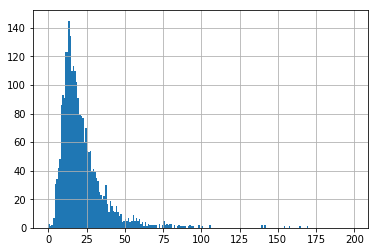

In [24]:
# tokenize the document
df['tokens'] = df['desc_'].apply(text_to_word_sequence)
lens = df['tokens'].apply(len)
lens.hist(bins=[x for x in range(200)])

In [25]:
from nltk.corpus import stopwords as st
exceptions = ['a', 'off', 'against', 'between', 'into', 'through', 'above', 'below', 'up', 'down', 'out', 'in', 'over', 'further', 'of', 'on']
stopwords = set(st.words('english'))
for w in exceptions:
    stopwords.remove(w) 

In [26]:
#Remove Stopwords
df['tokens_sw'] = df['tokens'].apply(lambda d: [w for w in d if w not in stopwords])

In [27]:
def deleteLowCount(t, threshold=10):
    lcw = [w for w,c in t.word_counts.items() 
           if c < threshold 
           or w in all_names 
           or any(i.isdigit() for i in w)
          ]
    print(f"{len(lcw)} low counted, {len(t.word_counts) - len(lcw)} left")
    for w in lcw:
        del t.word_index[w]
        del t.word_docs[w]
        del t.word_counts[w]
    return t

In [28]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    lemmas = []
    for w, tag in nltk.pos_tag(text):
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        lemmas.append(lemmatizer.lemmatize(w, wntag) if wntag else w)
    return lemmas

df['lemmatized'] = df['tokens_sw'].apply(lemmatize_text)

In [30]:
from keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(df['lemmatized'])
t = deleteLowCount(t, 5)
rT = dict(map(reversed, t.word_index.items()))
df['sequence'] = t.texts_to_sequences(df['lemmatized'])

filtered = df['sequence'].apply(lambda x: [rT[num] for num in x])
t = Tokenizer()
t.fit_on_texts(filtered)
df['sequence'] = t.texts_to_sequences(filtered)
rT = dict(map(reversed, t.word_index.items()))
numDistinctWords = len(t.word_index) + 1

3706 low counted, 829 left


In [31]:
df.head()

,desc_,hand_,length_,line_,outcome_,tokens,tokens_sw,lemmatized,sequence
0,"Steyn to Jaques, full and on the legs, swinging in, Jaques lets it go past, no runs, fielded by Boucher",1,2,2,0,"[steyn, to, jaques, full, and, on, the, legs, swinging, in, jaques, lets, it, go, past, no, runs, fielded, by, boucher]","[steyn, jaques, full, on, legs, swinging, in, jaques, lets, go, past, runs, fielded, boucher]","[steyn, jaques, full, on, leg, swing, in, jaques, let, go, past, run, field, boucher]","[15, 3, 10, 56, 5, 125, 21, 69, 30, 90]"
1,"Steyn to Jaques, good length but down leg, Jaques drives, no runs, fielded by Botha",1,3,3,0,"[steyn, to, jaques, good, length, but, down, leg, jaques, drives, no, runs, fielded, by, botha]","[steyn, jaques, good, length, down, leg, jaques, drives, runs, fielded, botha]","[steyn, jaques, good, length, down, leg, jaques, drive, run, field, botha]","[17, 6, 18, 10, 24, 30, 90]"
2,"Steyn to Jaques, short of a length outside the off stump, Jaques plays no shot, no runs, fielded by Boucher",1,4,1,0,"[steyn, to, jaques, short, of, a, length, outside, the, off, stump, jaques, plays, no, shot, no, runs, fielded, by, boucher]","[steyn, jaques, short, of, a, length, outside, off, stump, jaques, plays, shot, runs, fielded, boucher]","[steyn, jaques, short, of, a, length, outside, off, stump, jaques, play, shoot, run, field, boucher]","[13, 4, 1, 6, 8, 2, 11, 41, 432, 30, 90]"
3,"(no ball) Steyn to Jaques, good length delivery just outside the off stump, Jaques lets it go past, no runs, fielded by Boucher",1,3,1,4,"[no, ball, steyn, to, jaques, good, length, delivery, just, outside, the, off, stump, jaques, lets, it, go, past, no, runs, fielded, by, boucher]","[ball, steyn, jaques, good, length, delivery, outside, off, stump, jaques, lets, go, past, runs, fielded, boucher]","[ball, steyn, jaques, good, length, delivery, outside, off, stump, jaques, let, go, past, run, field, boucher]","[7, 17, 6, 37, 8, 2, 11, 125, 21, 69, 30, 90]"
4,"Steyn to Jaques, fuller length outside the off stump , Jaques drives in air over cover fielder, 4 runs",1,2,1,12,"[steyn, to, jaques, fuller, length, outside, the, off, stump, jaques, drives, in, air, over, cover, fielder, 4, runs]","[steyn, jaques, fuller, length, outside, off, stump, jaques, drives, in, air, over, cover, fielder, 4, runs]","[steyn, jaques, fuller, length, outside, off, stump, jaques, drive, in, air, over, cover, fielder, 4, run]","[81, 6, 8, 2, 11, 24, 5, 166, 23, 16, 106, 30]"


In [32]:
count = defaultdict(int)
threshold = 100
for x in df['sequence']:
    for i in range(len(x), threshold+1):
        count[i] += 1
        
total = len(df['sequence'])
for num, c in sorted(list(count.items()), key=lambda x:x[1], reverse=True)[60:80]:
    print(f"{num:<3} - {(c*100/total):>3.2f}%")

40  - 98.39%
39  - 98.28%
38  - 98.09%
37  - 97.97%
36  - 97.86%
35  - 97.63%
34  - 97.47%
33  - 97.24%
32  - 96.82%
31  - 96.55%
30  - 96.36%
29  - 95.98%
28  - 95.44%
27  - 94.94%
26  - 94.64%
25  - 93.76%
24  - 93.30%
23  - 92.49%
22  - 91.27%
21  - 89.74%


In [33]:
df.columns

Index(['desc_', 'hand_', 'length_', 'line_', 'outcome_', 'tokens', 'tokens_sw',
       'lemmatized', 'sequence'],
      dtype='object')

# Model training

In [51]:
def getModel(evl=15, cells=15):
    model = Sequential()
    model.add(Embedding(numDistinctWords, evl, input_length=max_comm_length))
    model.add(LSTM(cells, dropout=0.1))
    model.add(Dense(6, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def train_and_evaluate(model, X_train, X_test, y_train, y_test, epochs, batch_size, evl, cells):
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), np.ravel(y_train))
    class_weights = dict(enumerate(class_weights))
    callbacks = [EarlyStopping(monitor='val_loss', patience=5),
                 ModelCheckpoint('models/length_model.h5', save_best_only=True, 
                                 save_weights_only=False)]
    model.fit(X_train, y_train, validation_data=(X_test, y_test), 
              callbacks=callbacks, epochs=epochs, batch_size=batch_size)
    return model.evaluate(X_test, y_test, verbose=0)

In [52]:
X_cols = ['sequence']
y_cols = ['length_']
n_folds = 5

X, X_test, y, y_test = train_test_split(df[X_cols], df[y_cols], stratify = df[y_cols], test_size=0.1, random_state=seed)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

max_comm_length = 25
X = sequence.pad_sequences(X['sequence'], maxlen=max_comm_length, truncating='post', padding='post')
X_test = sequence.pad_sequences(X_test['sequence'], maxlen=max_comm_length, truncating='post', padding='post')
# X = np.append(X_seq, X['outcome'].values.reshape(-1,1), axis=1)
# X_test = np.append(X_test, X_test['outcome'].values.reshape(-1,1), axis=1)

y = y.values

In [53]:
scores = []
epochs = 12
batch_size = 4
evl = 12
cells = 10
for i, (train_fold, test_fold) in enumerate(skf.split(X,y)):
    print(f"Running fold {i+1} / {n_folds}")
    model = getModel()
    train_x, test_x = X[train_fold], X[test_fold]
    train_y, test_y = y[train_fold], y[test_fold]
    s = train_and_evaluate(model, train_x, test_x, train_y, test_y, epochs, batch_size, evl, cells)
    scores.append(s)

Running fold 1 / 5
Train on 1878 samples, validate on 471 samples
Epoch 1/12
1878/1878 [==============================] - 6s 3ms/step - loss: 1.3166 - accuracy: 0.4702 - val_loss: 1.0413 - val_accuracy: 0.6200
Epoch 2/12
1878/1878 [==============================] - 5s 3ms/step - loss: 0.9644 - accuracy: 0.6379 - val_loss: 0.8662 - val_accuracy: 0.6539
Epoch 3/12
1878/1878 [==============================] - 5s 3ms/step - loss: 0.8083 - accuracy: 0.6917 - val_loss: 0.8234 - val_accuracy: 0.6879
Epoch 4/12
1878/1878 [==============================] - 5s 3ms/step - loss: 0.7252 - accuracy: 0.7252 - val_loss: 0.8038 - val_accuracy: 0.6900
Epoch 5/12
1878/1878 [==============================] - 5s 3ms/step - loss: 0.6778 - accuracy: 0.7417 - val_loss: 0.7973 - val_accuracy: 0.6879
Epoch 6/12
1878/1878 [==============================] - 5s 3ms/step - loss: 0.6169 - accuracy: 0.7657 - val_loss: 0.7377 - val_accuracy: 0.7431
Epoch 7/12
1878/1878 [==============================] - 5s 3ms/step - 

In [54]:
print(f"accuracy: {np.array([i[1] for i in scores]).mean()}")

accuracy: 0.7156687021255493


In [50]:
model = getModel()
model.fit(X, y, epochs=epochs, batch_size=batch_size)
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/12
 344/2349 [===>..........................] - ETA: 8s - loss: 1.6448 - accuracy: 0.3953

KeyboardInterrupt: 

In [ ]:
y_pred = model.predict(X_test)
labels = np.unique(y_train)
matrix = confusion_matrix(y_test.values, y_pred.argmax(axis=1), labels=labels)
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
pd.DataFrame(matrix, index=labels, columns=labels)

In [ ]:
np.set_printoptions(suppress=True, precision=3)
lengths = {
    0: 'full toss',
    1: 'yorker',
    2: 'full',
    3: 'good length',
    4: 'back of a length',
    5: 'short'
}
y_proba = model.predict_proba(X_test)
y_max = y_pred.argmax(axis=1)
for i, probs in enumerate(y_proba):
        
    predictedMax = lengths[y_max[i]]
    actualMax = lengths[y_test.values[i][0]]
    commentary = printSequence(X_test[i])
    if max(probs) < 0.5:
        print(f"{predictedMax:<20} {actualMax:<20} - {commentary}")

In [849]:
#20 min doc, 8 bs, 10 epoch, 10 vec length, 15 max_comms
def printSequence(seq):
    return " ".join([rT[num] for num in seq if num in rT])
    
def testPhrase(phrase):
    splitup = text_to_word_sequence(phrase)
    arr = t.texts_to_sequences([splitup])
    seq = sequence.pad_sequences(arr, maxlen=max_comm_length, truncating='post', padding='post')
    model.predict(seq).argmax(axis=1)